In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



file = "train_ZoGVYWq.csv"
data = pd.read_csv(file)

def pre_prep(df):
    data = df.copy()
    data.set_index('id', inplace=True)
    data['renewal'] = data['renewal'].astype('bool')
    data['sourcing_channel'] = data['sourcing_channel'].astype('category') 
    data['residence_area_type'] = data['residence_area_type'].astype('category')
    new_names = {'perc_premium_paid_by_cash_credit': 'cash_credit',
                'Count_3-6_months_late': 'late3',
                'Count_6-12_months_late': 'late6',
                'Count_more_than_12_months_late': 'late12',
                'application_underwriting_score': 'score',
                'residence_area_type': 'residence',
                'no_of_premiums_paid': 'prems_paid',
                'sourcing_channel': 'channel'}
    data.rename(index=str, columns=new_names, inplace=True)
    return data

data_pre_prepped = pre_prep(data)

In [133]:
data_pre_prepped.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,channel,residence,premium,renewal
id,,,,,,,,,,,,
110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,True
41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,True
31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,False
19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,True
99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,True


In [178]:
from sklearn.model_selection import train_test_split

def create_dummies(df):
    df_new = pd.get_dummies(data=df.copy(), prefix='channel', columns=['channel'], drop_first=False)
    df_new = pd.get_dummies(data=df_new, prefix='residence', columns=['residence'], drop_first=False)
    return df_new

data_with_dummies = create_dummies(data_pre_prepped)

X_train, X_test, y_train, y_test = \
train_test_split(data_with_dummies.drop('renewal', axis=1), data_pre_prepped['renewal'], test_size=0.20, random_state=42)

# train_test_split(data_pre_prepped, data_pre_prepped['renewal'], test_size=0.20, random_state=42)
len(data_with_dummies)

79853

In [135]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63882 entries, 56158 to 99690
Data columns (total 16 columns):
cash_credit        63882 non-null float64
age_in_days        63882 non-null int64
Income             63882 non-null int64
late3              63801 non-null float64
late6              63801 non-null float64
late12             63801 non-null float64
score              61534 non-null float64
prems_paid         63882 non-null int64
premium            63882 non-null int64
channel_A          63882 non-null uint8
channel_B          63882 non-null uint8
channel_C          63882 non-null uint8
channel_D          63882 non-null uint8
channel_E          63882 non-null uint8
residence_Rural    63882 non-null uint8
residence_Urban    63882 non-null uint8
dtypes: float64(5), int64(4), uint8(7)
memory usage: 5.3+ MB


 # Imputation
 

In [136]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_train[['score', 'late3', 'late6', 'late12']] = imp.fit_transform(X_train[['score', 'late3', 'late6', 'late12']])

In [137]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63882 entries, 56158 to 99690
Data columns (total 16 columns):
cash_credit        63882 non-null float64
age_in_days        63882 non-null int64
Income             63882 non-null int64
late3              63882 non-null float64
late6              63882 non-null float64
late12             63882 non-null float64
score              63882 non-null float64
prems_paid         63882 non-null int64
premium            63882 non-null int64
channel_A          63882 non-null uint8
channel_B          63882 non-null uint8
channel_C          63882 non-null uint8
channel_D          63882 non-null uint8
channel_E          63882 non-null uint8
residence_Rural    63882 non-null uint8
residence_Urban    63882 non-null uint8
dtypes: float64(5), int64(4), uint8(7)
memory usage: 5.3+ MB


# Transform categories

In [138]:

X_train_dummy.describe()
X_train_dummy.to_csv("train_imputed_encoded.csv")

# Transform numerics distributions (not for now)

# Train LogReg Model

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [140]:
m = LogisticRegression()

In [141]:
m.fit(X=X_train_dummy, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [146]:
m.coef_

array([[-5.27390676e-04,  7.16076451e-05,  1.25179892e-06,
        -1.39039126e-03, -9.94464830e-04, -5.97382053e-04,
         1.20915261e-02,  1.92622519e-04, -3.83326185e-07,
         1.95019623e-04, -1.09913258e-05, -1.90664195e-05,
        -4.26997503e-05, -3.88051449e-06,  4.94193409e-05,
         6.89622716e-05]])

## Prep model test input

In [153]:
sum(X_test.isnull().any(axis=1))

628

In [172]:
X_test_imp = X_test.copy()
X_test_imp[['score', 'late3', 'late6', 'late12']] = imp.transform(X_test_imp[['score', 'late3', 'late6', 'late12']])
# X_test_imp.head()
sum(X_test_imp.isnull().any(axis=1))

0

In [173]:
y_proba = m.predict_proba(X_test_imp)
# y_pred = m.predict(X_test_imp)
#print(classification_report(y_true=y_test, y_pred=y_pred))
y_proba.shape
y_proba[:,1]

array([0.93225953, 0.95626013, 0.94712773, ..., 0.94568368, 0.90781192,
       0.94813266])

In [177]:
print(classification_report(y_true=y_test, y_pred=y_proba[:,1]>.9))

             precision    recall  f1-score   support

      False       0.11      0.16      0.13      1032
       True       0.94      0.91      0.93     14939

avg / total       0.89      0.87      0.88     15971



(array([  8.,  11.,  23.,  37.,  27.,  41.,  53.,  68.,  80.,  93., 113.,
        108., 147., 149., 159., 161., 194., 202., 235., 253., 242., 253.,
        283., 324., 380., 395., 447., 480., 507., 565., 589., 613., 662.,
        704., 719., 755., 754., 780., 750., 773., 611., 609., 485., 407.,
        294., 185., 100.,  50.,  20.,  16.,  10.,  11.,   9.,   9.,  18.]),
 array([0.85590018, 0.85852017, 0.86114017, 0.86376017, 0.86638016,
        0.86900016, 0.87162016, 0.87424015, 0.87686015, 0.87948015,
        0.88210015, 0.88472014, 0.88734014, 0.88996014, 0.89258013,
        0.89520013, 0.89782013, 0.90044012, 0.90306012, 0.90568012,
        0.90830011, 0.91092011, 0.91354011, 0.9161601 , 0.9187801 ,
        0.9214001 , 0.92402009, 0.92664009, 0.92926009, 0.93188008,
        0.93450008, 0.93712008, 0.93974007, 0.94236007, 0.94498007,
        0.94760006, 0.95022006, 0.95284006, 0.95546005, 0.95808005,
        0.96070005, 0.96332005, 0.96594004, 0.96856004, 0.97118004,
        0.973800

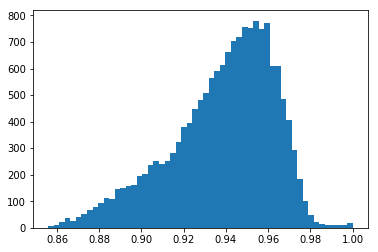

In [176]:
plt.hist(y_proba[:,1], bins='auto')

In [188]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba[:,1], pos_label=True)
roc_auc = metrics.roc_auc_score(y_test, y_proba[:,1])

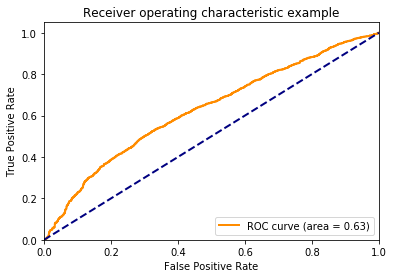

In [189]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()